<img align="right" src="https://github.aetna.com/raw/1651288/coldstart-oss/main/docs/images/coldstart.png?raw=true">

# Quickstart
___

#### Overview:

Blah blah blah

#### TODO:

1. a
2. b
3. c
4. d

### Prep Environment
___

In [22]:
# ! pip install coldstart --user

In [37]:
# automatically restart kernel after installs
import os
if not os.getenv("IS_TESTING"):
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

In [1]:
import os
import time
import numpy as np
import pandas as pd
import pandas_gbq
from datetime import datetime

# append system path - REMOVE THIS LATER
import sys
sys.path.insert(0, '/home/jupyter/coldstart-oss')

# plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
pd.plotting.register_matplotlib_converters()

# format notebook display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:.4f}'.format

# get project ID from gcloud
TIMESTAMP = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
PROJECT_ID = ''
if not os.getenv('IS_TESTING'):
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print(f'Start Time: {TIMESTAMP}')
    print(f'Project ID: {PROJECT_ID}')

Start Time: 2022-11-08 15:52:29
Project ID: anbc-dev


### Inspecting your Query Bank with `FeatureFactory`

Blah blah blah

Note that you can place queries in HERE or HERE.

___

In [2]:
from coldstart import FeatureFactory

# instantiate feature_factory
ff = FeatureFactory()

# list available dialects
dialects = ff.list_dialects()
print(f'Available dialects: {dialects}')

Available dialects: ['bigquery']


/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# list available entities
entities = ff.list_entities(dialect='bigquery')
print(f'Available entities: {entities}')

Available entities: ['team_id', 'game_id']


In [4]:
# list available domains
domains = ff.list_domains(dialect='bigquery', entity_id='team_id')
print(f'Available domains: {domains}')

Available domains: ['mascot', 'wins', 'losses', 'venue', 'taxonomy']


In [5]:
# list available queries
queries = ff.list_queries(dialect='bigquery', entity_id='team_id')
print(f'Available queries: {queries}')

Available queries: ['testQuery3', 'testQuery1', 'testQuery2', 'testQuery5', 'testQuery4']


### Defining your Leftmost Table

This table should contain the observations that you will use to train your model...

___

In [6]:
from sqlalchemy import create_engine

# write query
sql = """
CREATE OR REPLACE TABLE anbc-dev.dso_ent_dev.coldstart_test_leftmost_tmp
AS
WITH T1 AS (
    SELECT
        T.id AS team_id,
        G.season,
        CASE
            WHEN G.win = True Then 1
            ELSE 0
        END AS win_count,
        CASE
            WHEN G.win = False Then 1
            ELSE 0
        END AS loss_count
    FROM
        bigquery-public-data.ncaa_basketball.mbb_teams AS T
        LEFT JOIN bigquery-public-data.ncaa_basketball.mbb_historical_teams_games AS G
            ON T.id = G.team_id
    WHERE
        season >= EXTRACT(YEAR FROM DATE('2016-01-01'))
        AND season <= EXTRACT(YEAR FROM DATE('2016-01-01'))
)
SELECT
    T1.team_id,
    CASE
        WHEN SUM(T1.win_count) / (SUM(T1.win_count) + SUM(T1.loss_count)) > 0.5
        THEN 1
        ELSE 0
    END AS y
FROM
    T1
GROUP BY
    T1.team_id
ORDER BY
    y DESC
"""

# create engine
engine = create_engine("bigquery:///?ProjectId='anbc-dev'")

# execute query
with engine.connect() as connection:
    result = connection.execute(sql)

# view dataframe
leftmost_df = pd.DataFrame(result.fetchall(), columns=result._metadata.keys)
print(leftmost_df.shape)
leftmost_df.head()

(351, 2)


,team_id,y
0,fe406882-9f22-495e-9df6-ef357a6803c6,1
1,ca478771-aa3d-4231-81e0-b70f519134fb,1
2,5c7bf63f-bc39-43c5-9907-73b50b7a6b34,1
3,8ab00d43-840a-4c96-bdee-bf88fa6e3f11,1
4,f8c705b7-87d3-411a-9c8b-5124daab0469,1


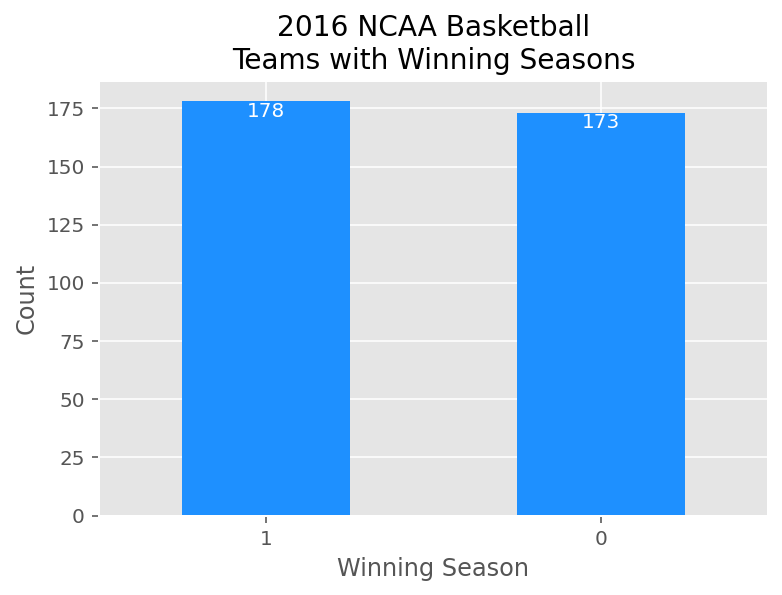

In [7]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            if _y > 1:
                ax.text(_x, _y, value, ha='center', va='top', color='w')
            else:
                ax.text(_x, _y, value, ha='center')
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

# plot
temp = leftmost_df['y'].value_counts()
with plt.style.context('ggplot'):
    ax = temp.plot.bar(rot=0, legend=False, color='dodgerblue')
    ax.set_title('2016 NCAA Basketball\nTeams with Winning Seasons', size=14)
    ax.set_xlabel('Winning Season', size=12)
    ax.set_ylabel('Count', size=12)
    show_values_on_bars(ax)
    plt.show()

### Staring your query engine with `FeatureFactory`
___

In [8]:
# set database spec
db_spec = {
    'dialect': 'bigquery',
    'project_id': PROJECT_ID,
    'schema': 'dso_ent_dev'
}

# start engine
ff.start_engine(db_spec)

### Generate features with `FeatureFactory`
___

In [9]:
# set tables
LEFTMOST_TABLE = 'anbc-dev.dso_ent_dev.coldstart_test_leftmost_tmp'
FEATURE_TABLE = 'anbc-dev.dso_ent_dev.coldstart_test_features_tmp'

# run feature factory
ff.run(
    leftmost_table=LEFTMOST_TABLE,
    feature_table=FEATURE_TABLE,
    entity_id='team_id',
    domains=domains,
    queries=None, # test this
    date_range=['2010-01-01', '2015-01-01'],
    query_dir=None, # test this
    export_dir=None, # test this
    return_df=True,
    compute_df=True,
    stop_on_error=False,
    downcast=False, # test this
    batching=False,
    batch_size=None,
)

In [20]:
# return dataframe
features_df = ff.get_dataframe().set_index('idx', drop=True)

# view dataframe
print(features_df.shape)
features_df.sample(5)

(351, 20)


,y,testQuery5_venue_state,testQuery5_venue_city,testQuery5_venue_capacity,testQuery1_win_count,testQuery2_loss_count,testQuery3_mascot_common_name,testQuery3_tax_subspecies,testQuery3_tax_species,testQuery3_tax_genus,testQuery3_tax_family,testQuery3_tax_order,testQuery3_tax_class,testQuery3_tax_phylum,testQuery3_tax_kingdom,testQuery3_tax_domain,testQuery3_non_tax_type,testQuery4_league,testQuery4_conference,testQuery4_division
idx,,,,,,,,,,,,,,,,,,,,
10f450ce-143b-4e46-8bfe-52c644b68b07_2010-01-01_2015-01-01,0,TX,Denton,10500,91,98,Brown Bear,None,arctos,Ursus,Ursidae,Carnivora,Mammalia,Chordata,Animalia,Eukaryota,None,NCAAM,CUSA,D1
10c614fa-9646-46cf-a1fb-5af96772bbb8_2010-01-01_2015-01-01,0,AL,Mobile,10041,81,101,Jaguar,None,onca,Panthera,Felidae,Carnivora,Mammalia,Chordata,Animalia,Eukaryota,None,NCAAM,SUNBELT,D1
12d7f888-675b-459f-9099-a38f771d8a95_2010-01-01_2015-01-01,1,IN,West Lafayette,14846,126,78,Human,None,sapiens,Homo,Hominidae,Primates,Mammalia,Chordata,Animalia,Eukaryota,Cratsmen,NCAAM,BIG10,D1
3db7336c-c18a-441b-912e-e2a4408f12ea_2010-01-01_2015-01-01,1,NJ,West Long Branch,4100,88,106,Hawk,None,None,None,Accipitridae,Accipitriformes,Aves,Chordata,Animalia,Eukaryota,None,NCAAM,MAAC,D1
fe406882-9f22-495e-9df6-ef357a6803c6_2010-01-01_2015-01-01,1,NJ,Princeton,6854,120,61,Tiger,None,tigris,Panthera,Felidae,Carnivora,Mammalia,Chordata,Animalia,Eukaryota,None,NCAAM,IVY,D1


In [11]:
# return table
features_table = ff.get_table()

# print table
print(f'Table name: {features_table}')

Table name: anbc-dev.dso_ent_dev.coldstart_test_features_tmp


In [12]:
# stop engine
ff.stop_engine()

### Checking `feature_table`
___

In [13]:
from sqlalchemy import create_engine

# write query
sql = f"""
SELECT *
FROM {FEATURE_TABLE}
"""

# create engine
engine = create_engine("bigquery:///?ProjectId='anbc-dev'")

# execute query
with engine.connect() as connection:
    result = connection.execute(sql)

# view dataframe
check_df = pd.DataFrame(result.fetchall(), columns=result._metadata.keys)
print(check_df.shape)
check_df.head()

(351, 21)


,idx,y,testQuery5_venue_state,testQuery5_venue_city,testQuery5_venue_capacity,testQuery1_win_count,testQuery2_loss_count,testQuery3_mascot_common_name,testQuery3_tax_subspecies,testQuery3_tax_species,testQuery3_tax_genus,testQuery3_tax_family,testQuery3_tax_order,testQuery3_tax_class,testQuery3_tax_phylum,testQuery3_tax_kingdom,testQuery3_tax_domain,testQuery3_non_tax_type,testQuery4_league,testQuery4_conference,testQuery4_division
0,8accb91e-6086-41b3-a420-7a82fa442365_2010-01-0...,1,NC,Elon,1585,99,93,None,None,None,None,None,None,None,None,None,None,Mythical Creatures,NCAAM,COLONIAL,D1
1,dfe0d93f-94a5-47fb-b7aa-f74786e09acb_2010-01-0...,0,IL,Chicago,9500,52,136,None,None,None,None,None,None,None,None,None,None,Dragons,NCAAM,HORIZON,D1
2,71874e7e-8260-43f9-bb7c-65f267dbe8ce_2010-01-0...,0,LA,Natchitoches,3900,101,86,None,None,None,None,None,None,None,None,None,None,Devils,NCAAM,SOUTHLAND,D1
3,0113eea0-c943-4fff-9780-ae0fb099e7ef_2010-01-0...,1,NY,Buffalo,2176,93,101,None,None,None,None,None,None,None,None,None,None,Griffins,NCAAM,MAAC,D1
4,881380da-861c-4ab6-a7d2-20699d8ea883_2010-01-0...,0,KY,Bowling Green,7326,110,91,None,None,None,None,None,None,None,None,None,None,None,NCAAM,CUSA,D1


### Modeling using the results dataframe/table
___

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, auc, roc_curve
from sklearn.calibration import calibration_curve

# construct pipeline
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, copy=False)),
        ('scaler', StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='NA', copy=False)),
        ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', categorical_transformer, make_column_selector(dtype_include=pd.CategoricalDtype)),
    ]
)
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('classifier', RandomForestClassifier()),
    ]
)

# set features and class label
X = features_df.iloc[:, 1:]
y = features_df.iloc[:, 0]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

# fit pipeline
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(copy=False,
                                                                                 fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb8959c690>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(copy=False,
           

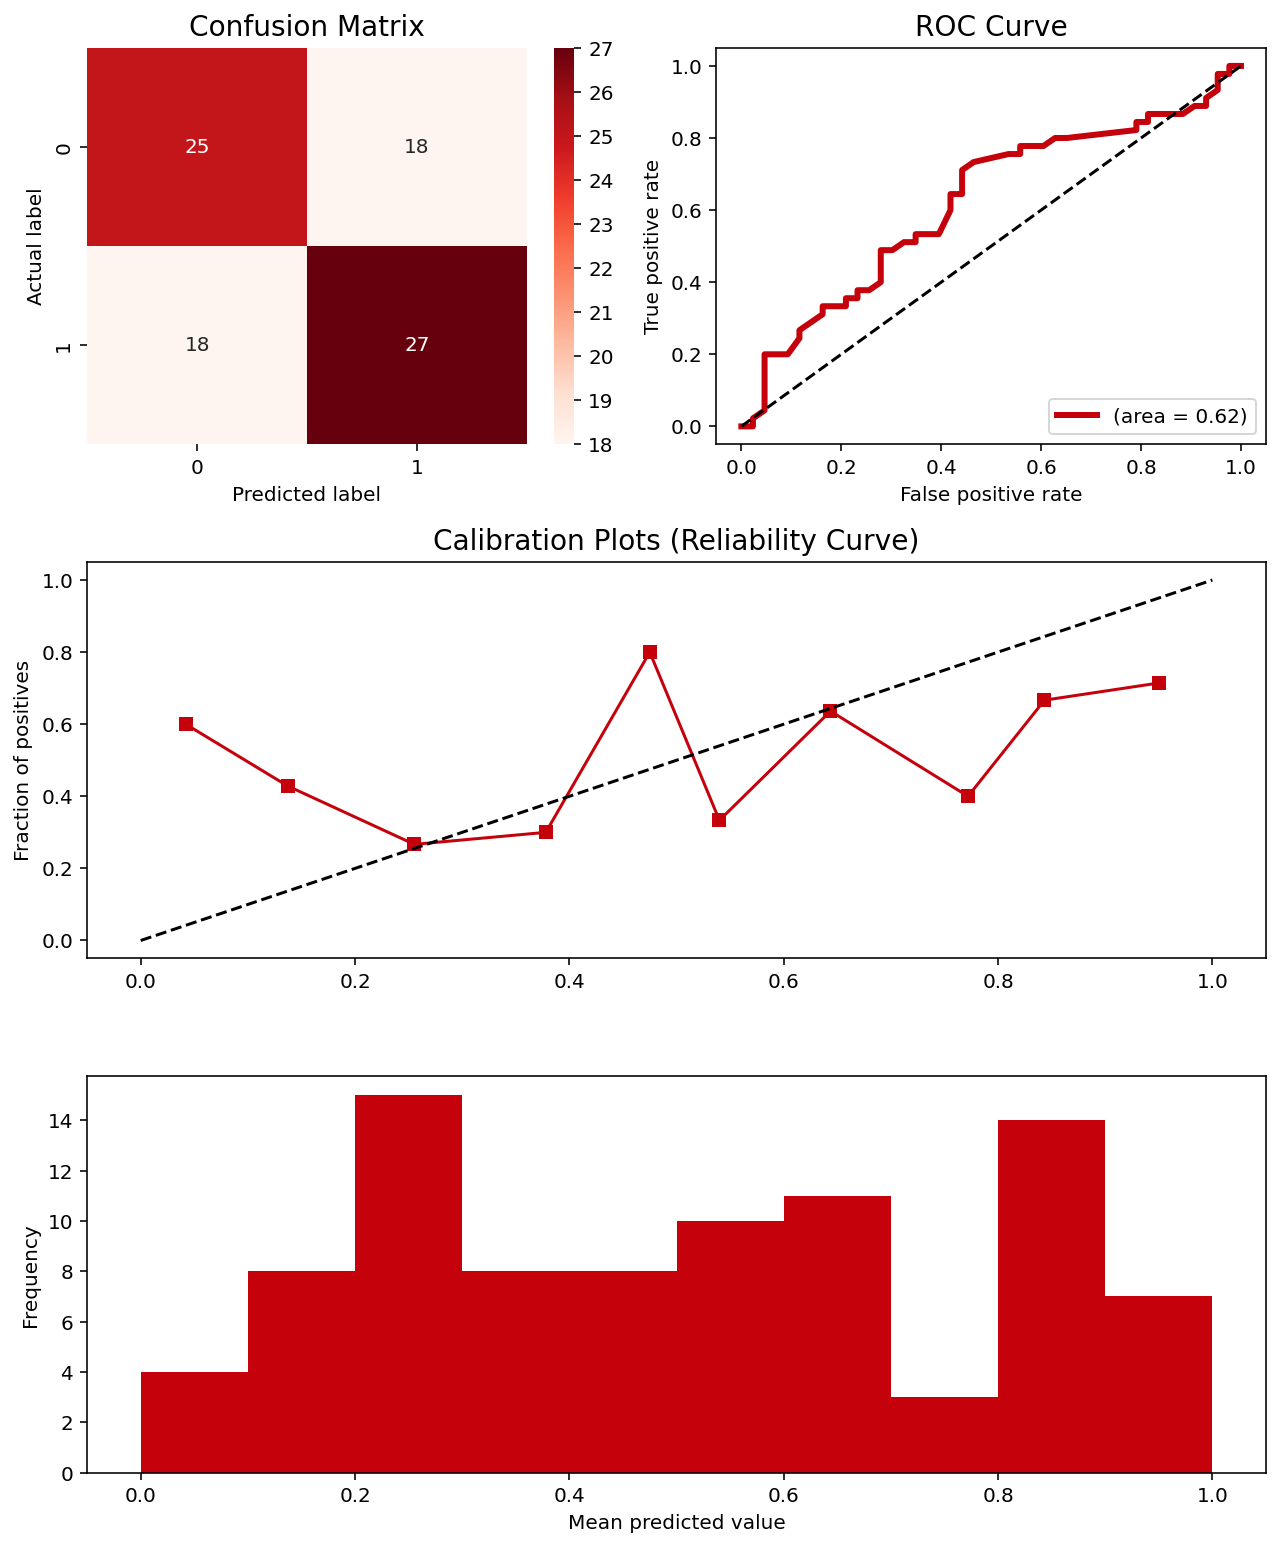

In [27]:
def clf_eval_viz(y_test, y_pred, y_proba, large=True): 
    
    # create subplot
    if large == True:
        plt.figure(figsize=(9, 14))
    else:
        plt.figure(figsize=(6, 9))
    ax1 = plt.subplot2grid((4,4), (0,0), colspan=2)
    ax2 = plt.subplot2grid((4,4), (0,2), colspan=2)
    ax3 = plt.subplot2grid((4,4), (1, 0), colspan=4)
    ax4 = plt.subplot2grid((4,4), (2, 0), colspan=4)
    
    # confusion matrix
    ax1.set_title('Confusion Matrix', fontsize=14)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='', cmap='Reds', ax=ax1)
    ax1.set_xlabel('Predicted label')
    ax1.set_ylabel('Actual label')
    
    # roc curve
    ax2.set_title('ROC Curve', fontsize=14)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    area = auc(fpr, tpr)
    ax2.plot(fpr, tpr, label='(area = %0.2f)' % area, linewidth=3, color='#c5010b')
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlabel('False positive rate')
    ax2.set_ylabel('True positive rate')
    ax2.legend(loc='lower right')
    
    # calculate fraction of positives and mean predicted value
    fop, mpv = calibration_curve(y_test, y_proba, n_bins=10)
    
    # calibration plot
    ax3.plot(mpv, fop, 's-', color='#c5010b')
    ax3.plot([0, 1], [0, 1], 'k--')
    ax3.set_ylabel('Fraction of positives')
    ax3.set_ylim([-0.05, 1.05])
    ax3.set_title('Calibration Plots (Reliability Curve)', fontsize=14)

    # mean probability by decile plot
    ax4.hist(y_proba, range=(0, 1), bins=10, histtype='stepfilled', lw=2, color='#c5010b')
    ax4.set_xlabel('Mean predicted value')
    ax4.set_ylabel('Frequency')
    
    # tight layout
    plt.tight_layout()
    plt.show()


# evaluate model
y_proba = pipe.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype('int')
clf_eval_viz(y_test, y_pred, y_proba, large=True)

In [ ]:
from sqlalchemy import create_engine

# write query
sql = """
SELECT
    *
FROM 
    bigquery-public-data.ncaa_basketball.mbb_historical_teams_games
"""

# create engine
engine = create_engine("bigquery:///?ProjectId='anbc-dev'")

# execute query
with engine.connect() as connection:
    result = connection.execute(sql)

# view dataframe
q = pd.DataFrame(result.fetchall(), columns=result._metadata.keys)
print(q.shape)
q.head()